### Train-test split

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 500)

random_seed = 2024
np.random.seed(random_seed)

In [489]:
bottle_data_path = '../data/bottle'

In [490]:
bottle_df = pd.read_csv(f'{bottle_data_path}/bottle_01.csv', index_col=0)

In [491]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536965 entries, 0 to 536964
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_Depth     536965 non-null  float64
 1   R_TEMP      529623 non-null  float64
 2   R_SALINITY  510592 non-null  float64
 3   R_SIGMA     507018 non-null  float64
 4   R_SVA       507022 non-null  float64
 5   R_DYNHT     514582 non-null  float64
 6   R_O2        406502 non-null  float64
 7   R_O2Sat     391582 non-null  float64
 8   R_SIO3      221752 non-null  float64
 9   R_PO4       247420 non-null  float64
 10  R_NO3       210148 non-null  float64
 11  R_NO2       209708 non-null  float64
 12  R_NH4       43565 non-null   float64
 13  R_CHLA      147881 non-null  float64
 14  R_PHAEO     147847 non-null  float64
 15  R_PRES      536965 non-null  float64
dtypes: float64(16)
memory usage: 69.6 MB


Perform a random train-test split of the data. R_PHAEO is a target feature here.

In [492]:
bottle_df_train, bottle_df_test = train_test_split(bottle_df, test_size=0.2, random_state=random_seed)

print(bottle_df_train.shape, bottle_df_test.shape)

(429572, 16) (107393, 16)


### Imputing and exploring

Let's impute missing data for each feature and explore their general properties.

In [493]:
def hist_plot(dataset, f_size=(10, 5)):
    plt.figure(figsize=f_size)
    sns.histplot(data=dataset, kde=False, bins=50)
    plt.plot()

def box_plot(dataset, f_size=(10, 5)):
    plt.figure(figsize=f_size)
    sns.boxplot(data=dataset.values)
    plt.plot()

In [494]:
def apply_z_score(col_name, z_score_col_name):
    col_mean = bottle_df_train[col_name].mean()
    col_std = bottle_df_train[col_name].std()

    bottle_df_train[z_score_col_name] = (bottle_df_train[col_name] - col_mean) / col_std
    bottle_df_test[z_score_col_name] = (bottle_df_test[col_name] - col_mean) / col_std

In [495]:
def impute_mean(col_name):
    col_mean = bottle_df_train[col_name].mean()

    train_null_count = bottle_df_train[col_name].isnull().sum()
    test_null_count = bottle_df_test[col_name].isnull().sum()

    bottle_df_train.loc[bottle_df_train[col_name].isnull(), col_name] = np.repeat(col_mean, train_null_count)
    bottle_df_test.loc[bottle_df_test[col_name].isnull(), col_name] = np.repeat(col_mean, test_null_count)

In [496]:
def impute_uniform(col_name, quantile_from=0.25, quantile_to=0.75):
    lower_quart = bottle_df_train[col_name].quantile(quantile_from)
    upper_quart = bottle_df_train[col_name].quantile(quantile_to)

    uniform_train = stats.uniform.rvs(loc=lower_quart, scale=upper_quart-lower_quart, size=bottle_df_train[col_name].isnull().sum())
    uniform_test = stats.uniform.rvs(loc=lower_quart, scale=upper_quart-lower_quart, size=bottle_df_test[col_name].isnull().sum())

    bottle_df_train.loc[bottle_df_train[col_name].isnull(), col_name] = uniform_train
    bottle_df_test.loc[bottle_df_test[col_name].isnull(), col_name] = uniform_test

#### R_Depth

Nothing to impute here.  There is a potential to normalizing and removing outliers if an algorithm requires it.

In [497]:
bottle_df_train['R_Depth'].isnull().sum()

0

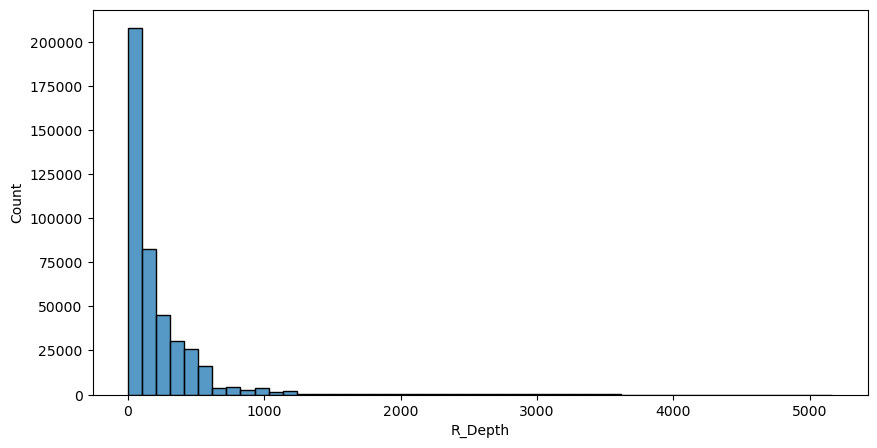

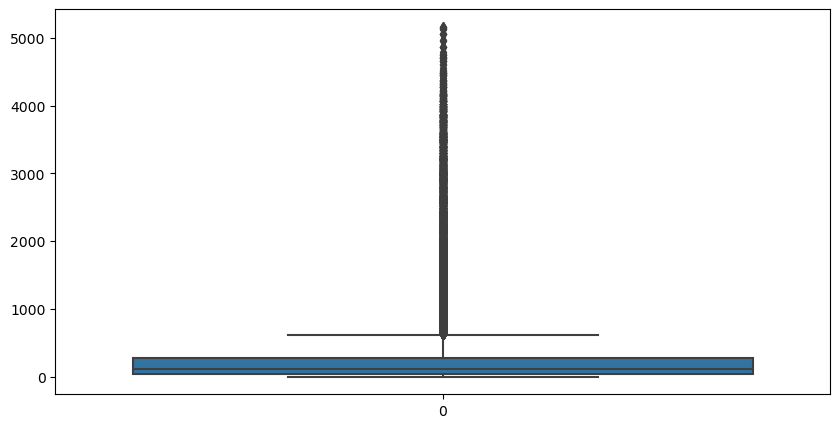

In [498]:
hist_plot(bottle_df_train['R_Depth'])
box_plot(bottle_df_train['R_Depth'])


#### R_TEMP

Here we see at least two modes in the discribution. For the missing values let's impute the uniformly distributed values between $0.25$ and $0.75$ quantiles, so that the original distribution is more or less maintained.

In [499]:
bottle_df_train['R_TEMP'].describe()

count    423690.000000
mean         10.979242
std           4.162453
min           1.440000
25%           7.920000
50%          10.300000
75%          13.960000
max          31.140000
Name: R_TEMP, dtype: float64

In [500]:
bottle_df_train['R_TEMP'].isnull().sum()

5882

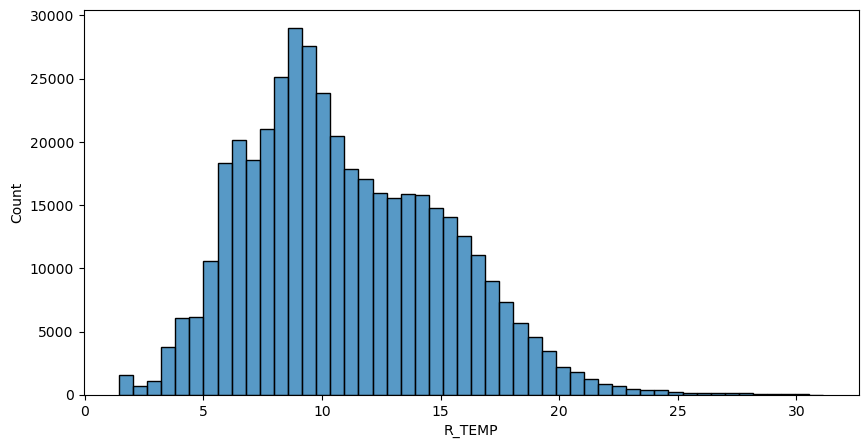

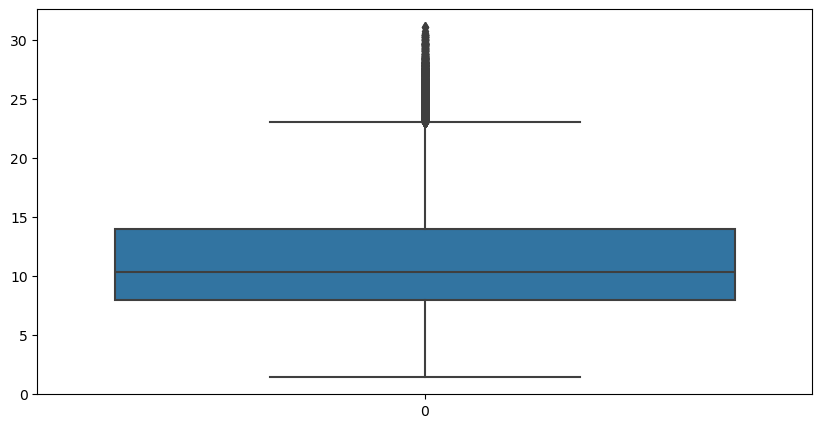

In [501]:
hist_plot(bottle_df_train['R_TEMP'])
box_plot(bottle_df_train['R_TEMP'])

In [502]:
impute_uniform('R_TEMP')

In [503]:
print(bottle_df_train['R_TEMP'].isnull().sum(), bottle_df_test['R_TEMP'].isnull().sum())

0 0


In [504]:
bottle_df_train['R_TEMP'].describe()

count    429572.000000
mean         10.978921
std           4.138866
min           1.440000
25%           7.960000
50%          10.320000
75%          13.910000
max          31.140000
Name: R_TEMP, dtype: float64

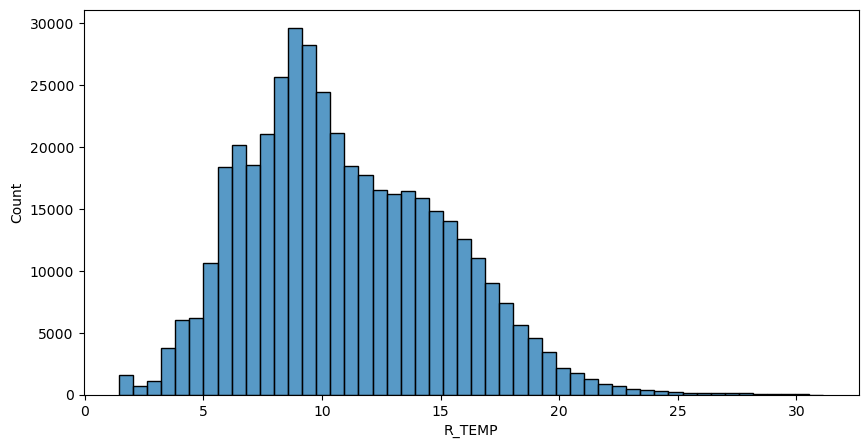

In [505]:
hist_plot(bottle_df_train['R_TEMP'])

#### R_SALINITY

Here the distribution resembles a normal one. Let's impute a mean value then.

In [506]:
bottle_df_train['R_SALINITY'].describe()

count    408448.000000
mean         33.820621
std           0.459943
min          28.431000
25%          33.477000
50%          33.822000
75%          34.174000
max          37.034000
Name: R_SALINITY, dtype: float64

In [507]:
bottle_df_train['R_SALINITY'].isnull().sum()

21124

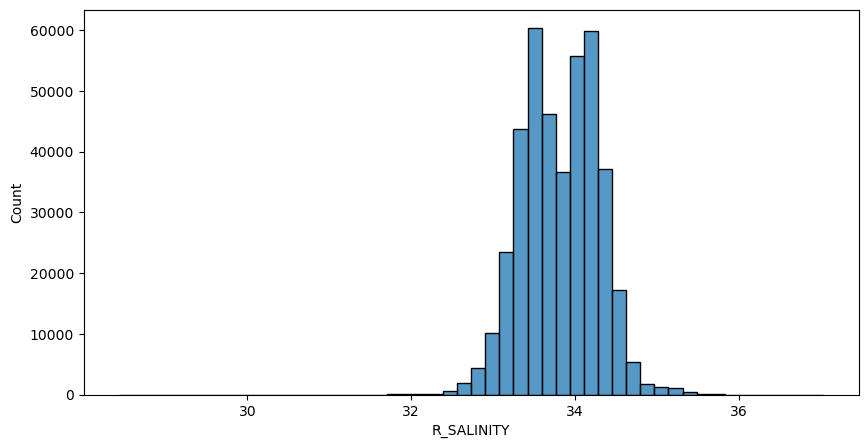

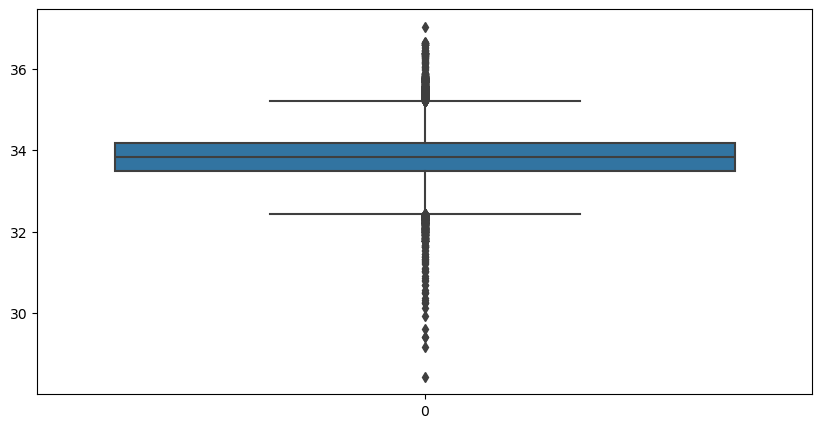

In [508]:
hist_plot(bottle_df_train['R_SALINITY'])
box_plot(bottle_df_train['R_SALINITY'])

In [509]:
impute_mean('R_SALINITY')
# apply_z_score('R_SALINITY', 'SALINITY_z')

In [510]:
print(bottle_df_train['R_SALINITY'].isnull().sum(), bottle_df_test['R_SALINITY'].isnull().sum())
# print(bottle_df_train['SALINITY_z'].isnull().sum(), bottle_df_test['SALINITY_z'].isnull().sum())

0 0


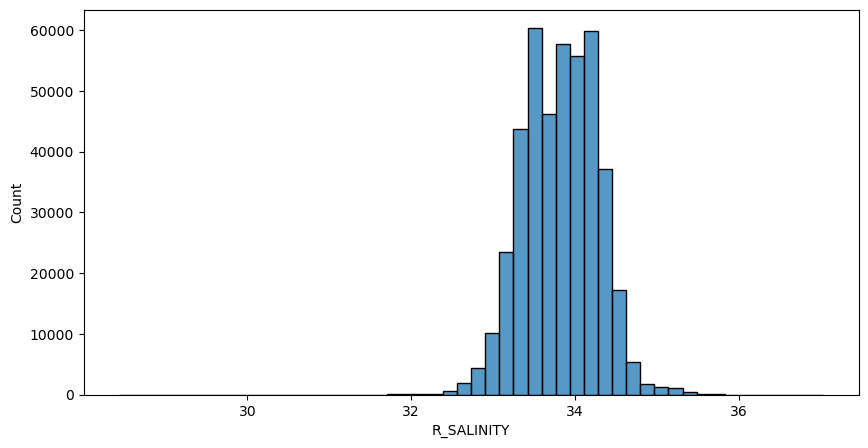

In [511]:
hist_plot(bottle_df_train['R_SALINITY'])

#### R_SVA

Again, here I'll impute the uniformly distributed values between $0.25$ and $0.75$ quantiles.

## R_SIGMA

Reported Potential Density of water

In [22]:
print(bottle_df_train['R_SIGMA'].isnull().sum(), bottle_df_test['R_SIGMA'].isnull().sum())

1878 503


Even though this number might seem high, it is less than 1 percent.

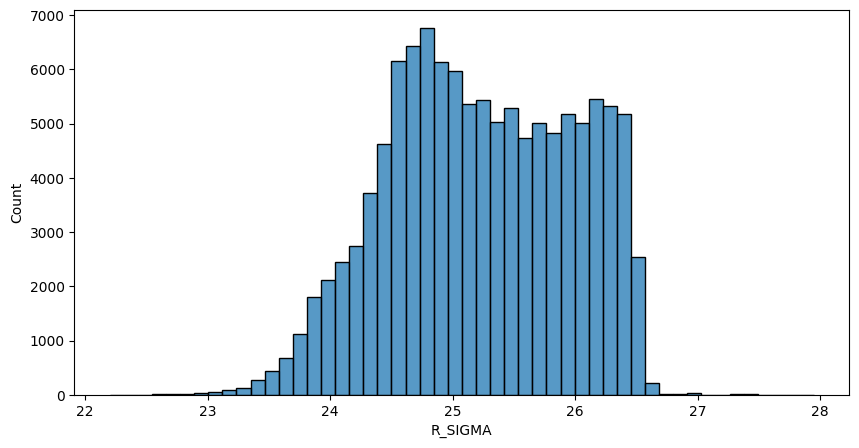

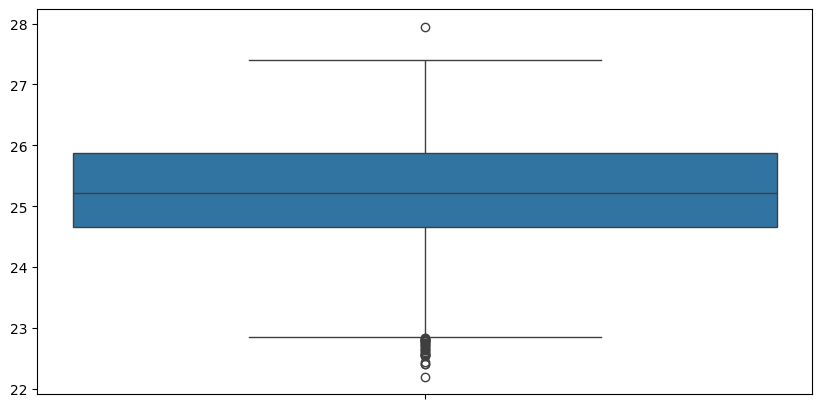

In [23]:
hist_plot(bottle_df_train['R_SIGMA'])
box_plot(bottle_df_train['R_SIGMA'])

## R_DYNHT

Reported Dynamic Height in units of dynamic meters (work per unit mass)

In [24]:
print(bottle_df_train['R_DYNHT'].isnull().sum(), bottle_df_test['R_DYNHT'].isnull().sum())

1779 478


The number of missing values is < 1%

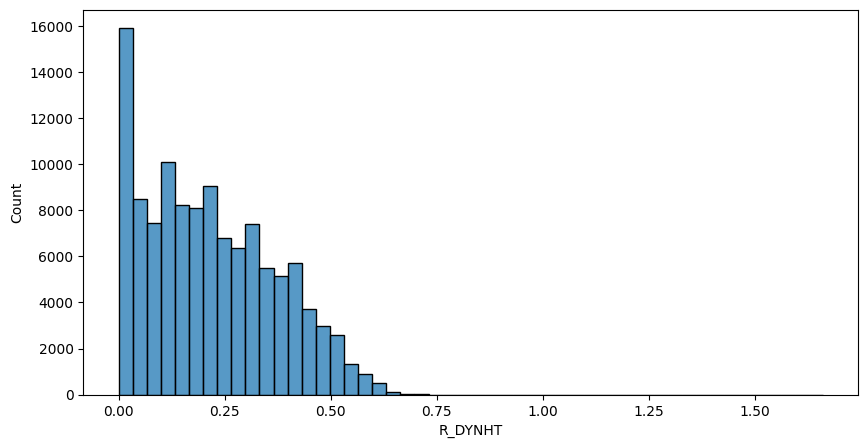

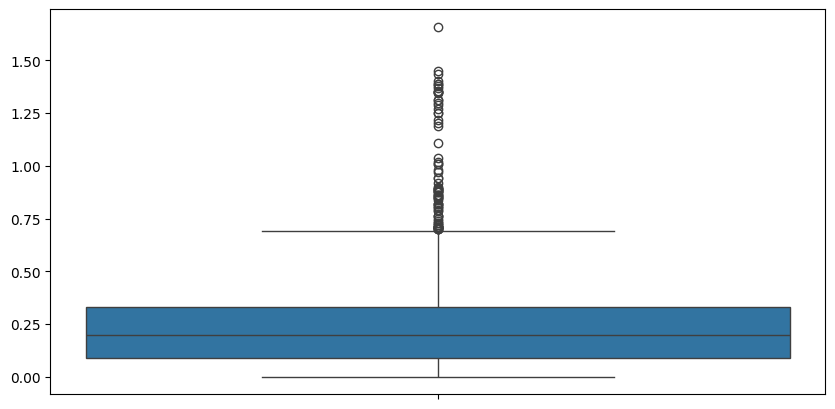

In [25]:
hist_plot(bottle_df_train['R_DYNHT'])
box_plot(bottle_df_train['R_DYNHT'])

## R_O2SAT

Reported Oxygen Saturation

In [26]:
print(bottle_df_train['R_O2Sat'].isnull().sum(), bottle_df_test['R_O2Sat'].isnull().sum())

2241 603


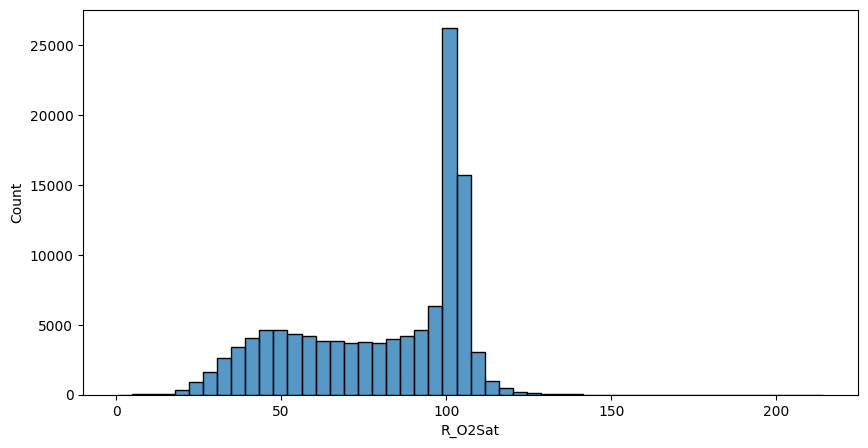

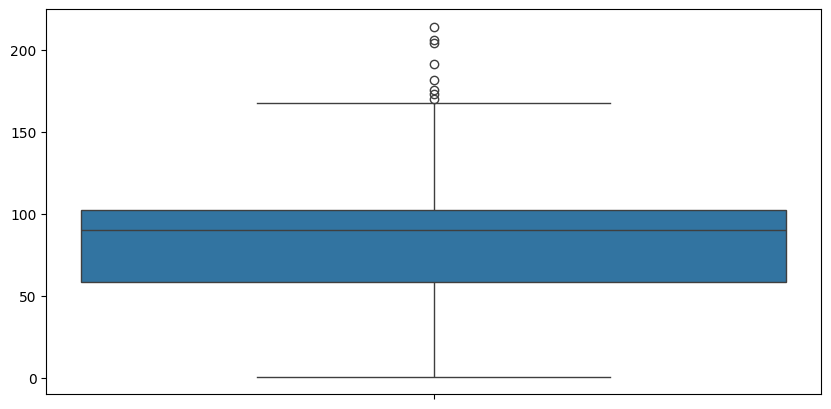

In [27]:
hist_plot(bottle_df_train['R_O2Sat'])
box_plot(bottle_df_train['R_O2Sat'])

## R_PO4

Reported Phosphate Concentration

In [28]:
print(bottle_df_train['R_PO4'].isnull().sum(), bottle_df_test['R_PO4'].isnull().sum())

5519 1352


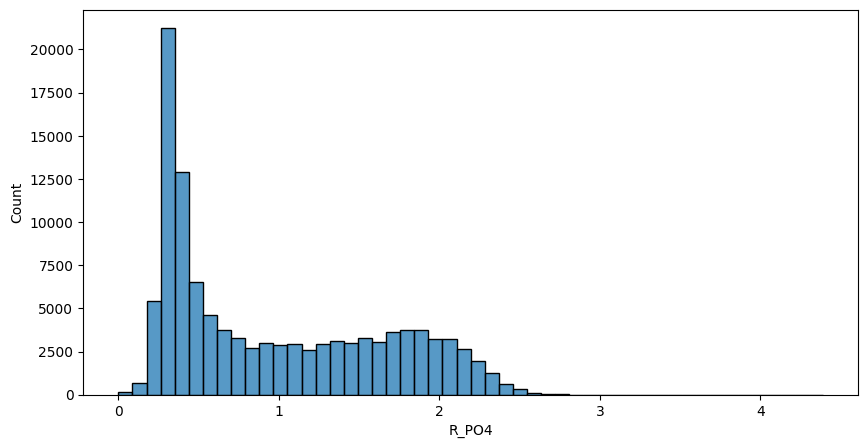

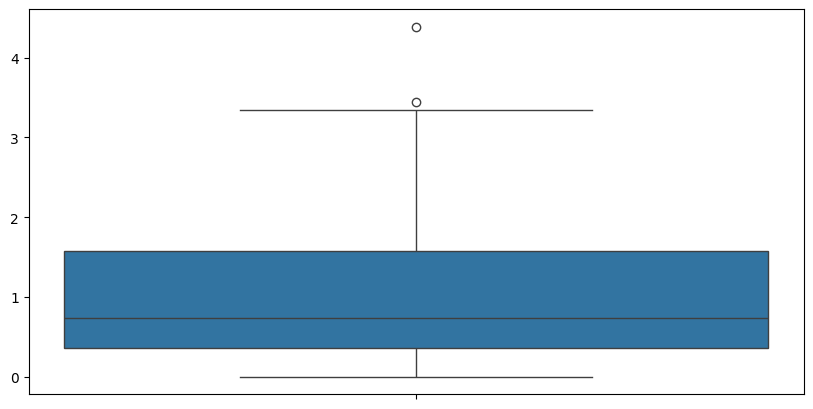

In [29]:
hist_plot(bottle_df_train['R_PO4'])
box_plot(bottle_df_train['R_PO4'])

## R_NO2

Reported Nitrite Concentration

In [30]:
print(bottle_df_train['R_NO2'].isnull().sum(), bottle_df_test['R_NO2'].isnull().sum())

8835 2202


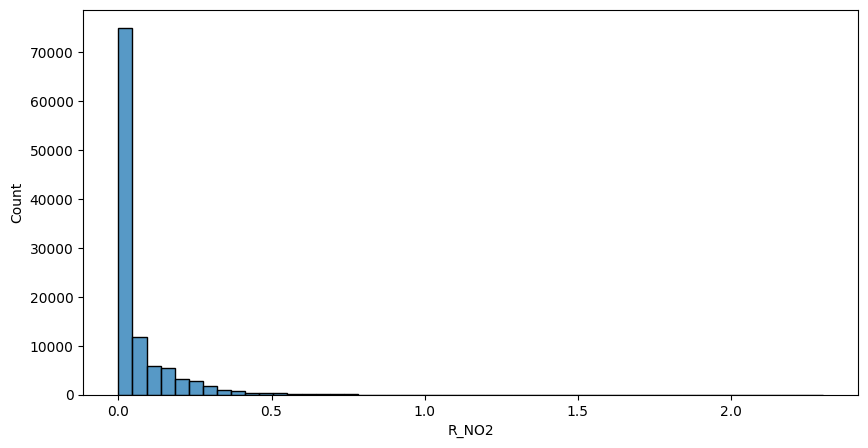

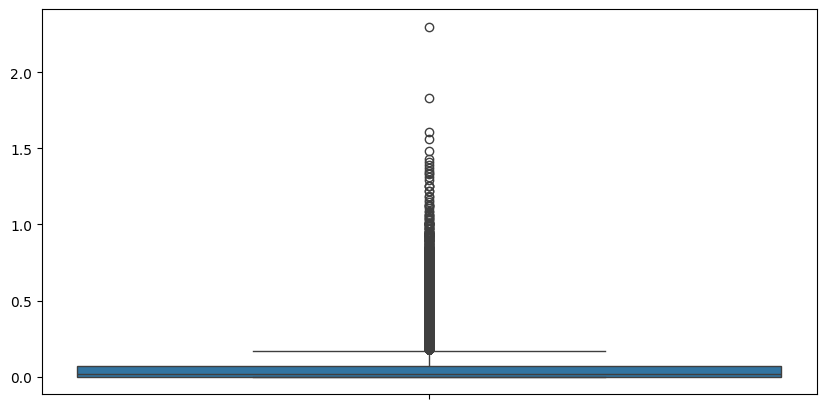

In [31]:
hist_plot(bottle_df_train['R_NO2'])
box_plot(bottle_df_train['R_NO2'])

In [32]:
bottle_df_train['R_SVA'].describe()

count    405586.000000
mean        224.576447
std          91.901844
min           7.300000
25%         147.100000
50%         210.600000
75%         301.300000
max         683.400000
Name: R_SVA, dtype: float64

In [513]:
bottle_df_train['R_SVA'].isnull().sum()

23986

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


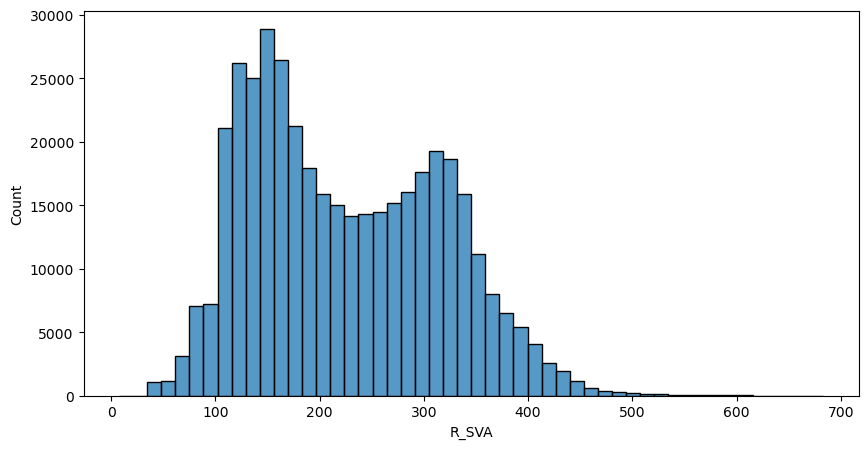

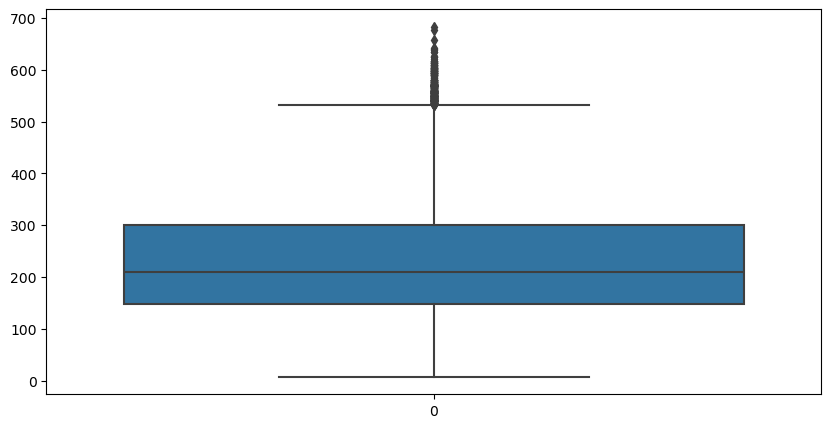

In [514]:
hist_plot(bottle_df_train['R_SVA'])
box_plot(bottle_df_train['R_SVA'])

In [515]:
impute_uniform('R_SVA')

In [516]:
print(bottle_df_train['R_SVA'].isnull().sum(), bottle_df_test['R_SVA'].isnull().sum())

0 0


c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


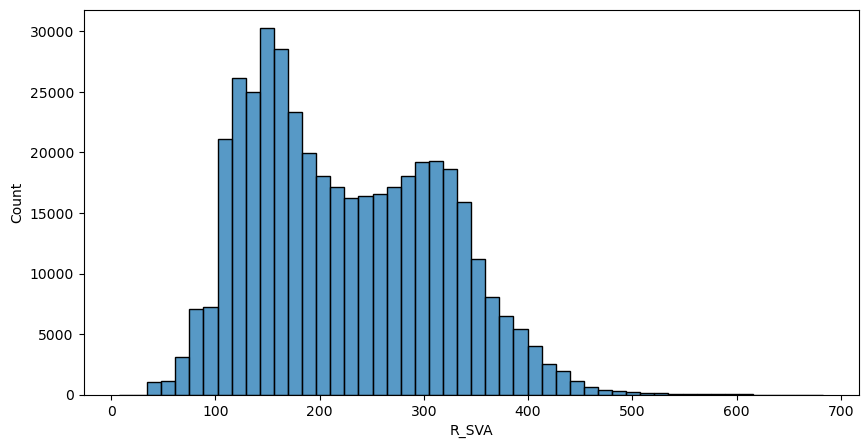

In [517]:
hist_plot(bottle_df_train['R_SVA'])

#### R_O2

Again, here multimodality is even more prominent. Let's impute values from uniform distribution.

In [518]:
bottle_df_train['R_O2'].describe()

count    324827.000000
mean          3.521522
std           2.050897
min          -0.010000
25%           1.580000
50%           3.710000
75%           5.540000
max          11.130000
Name: R_O2, dtype: float64

In [519]:
bottle_df_train['R_O2'].isnull().sum()

104745

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


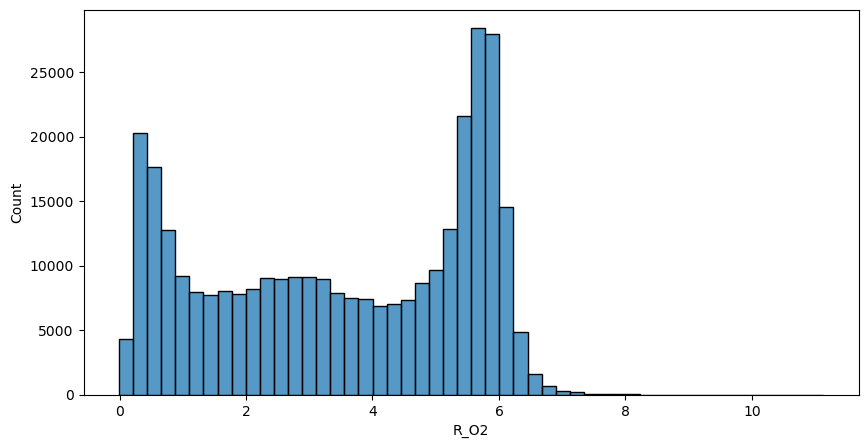

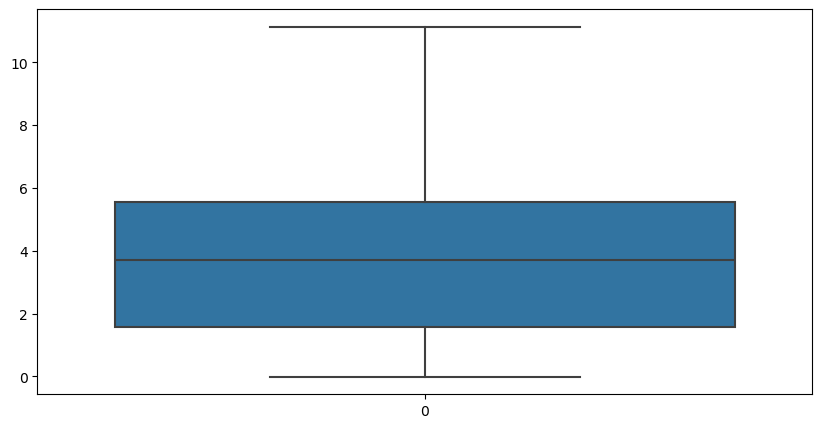

In [520]:
hist_plot(bottle_df_train['R_O2'])
box_plot(bottle_df_train['R_O2'])

In [521]:
impute_uniform('R_O2', quantile_from=0.05, quantile_to=0.95)

In [522]:
print(bottle_df_train['R_O2'].isnull().sum(), bottle_df_test['R_O2'].isnull().sum())

0 0


c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


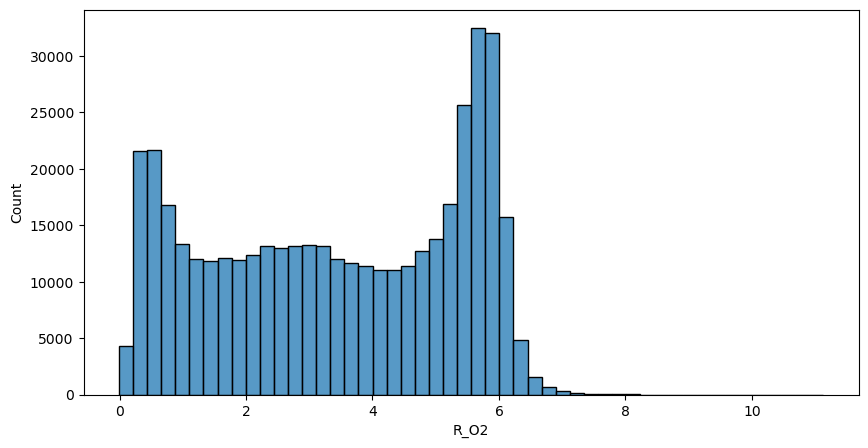

In [523]:
hist_plot(bottle_df_train['R_O2'])